{ФКИИ} Лабораторная работа №1 (Градиентный спуск и его модификации)

Выполнил студент уч. группы М8О-109СВ-24 Дрёмов А.С.

- Выбрать [тестовые функции оптимизации](https://ru.wikipedia.org/wiki/Тестовые_функции_для_оптимизации) (2 шт.)
- Запрограммировать собственную реализацию классического градиентного спуска
- Запрограммировать pipeline тестирования алгоритма оптимизации
  - Визуализации функции и точки оптимума
  - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
  - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
- Запрограммировать метод вычисления градиента
  - Передача функции градиента от пользователя
  - Символьное вычисление градиента (например с помощью [sympy](https://www.sympy.org/en/index.html)) (на доп. балл)
  - Численная аппроксимация градиента (на доп. балл)
- Запрограммировать одну моментную модификацию и протестировать ее
- Запрограммировать одну адаптивную модификацию и протестировать ее
- Запрограммировать метод эволюции темпа обучения и/или метод выбора начального приближения и протестировать их

In [1]:
import numpy as np
import sympy as sp
import plotly.graph_objects as go

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

Будем хранить всю информацию о ФО в виде класса

In [2]:
class OptimizationFunction:

    def __init__(self, function, domain, real_min, name):
        self.function = function
        self.domain = domain
        self.real_min = real_min
        self.name = name

Функция Бута

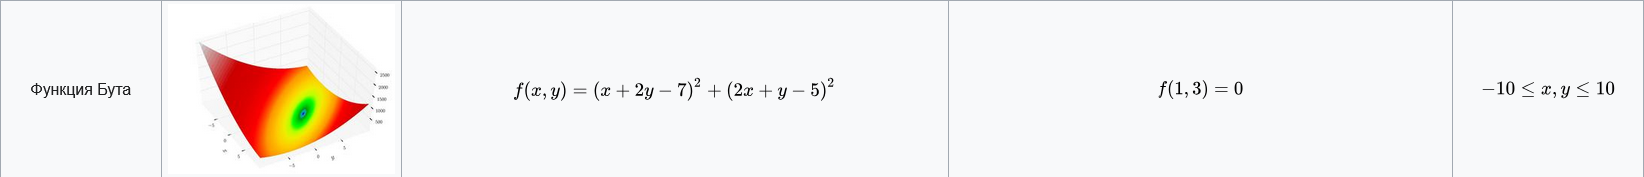

In [3]:
booth_function = OptimizationFunction(
    function = lambda x, y: (x + 2 * y - 7)**2 + (2 * x + y - 5)**2,
    domain=np.array([[-10, -10], [10, 10]]),
    real_min=np.array([1, 3, 0]),
    name='booth_function',
)

Функция Шаффера N2

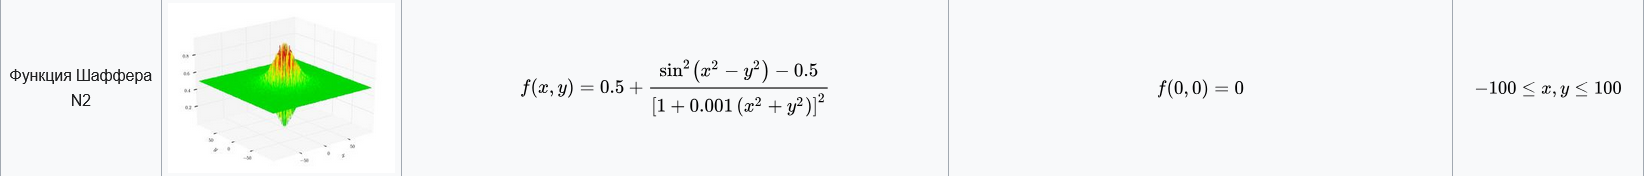

In [4]:
schaffer_n2_function = OptimizationFunction(
    function = lambda x, y: 0.5 + (np.sin(x**2 - y**2)**2 - 0.5) / (1 + 0.001 * (x**2 + y**2))**2,
    domain=np.array([[-100, -100], [100, 100]]),
    real_min=np.array([0, 0, 0]),
    name='schaffer_n2_function',
)

Визуализация точки найденного решения (без анимации)

In [5]:
def visualize_GD_static(test_function, path, title):
    function = test_function.function
    domain = test_function.domain
    real_min = test_function.real_min
    name = test_function.name

    x = np.linspace(domain[0, 0], domain[1, 0], 100)
    y = np.linspace(domain[0, 1], domain[1, 1], 100)
    x_grid, y_grid = np.meshgrid(x, y)

    z_grid = function(x_grid, y_grid)

    surface = go.Surface(z=z_grid, x=x_grid, y=y_grid, colorscale='Plasma', opacity=0.5, showscale=False)

    path_trace = go.Scatter3d(x=path[:, 0], y=path[:, 1], z=path[:, 2], mode='lines+markers',
                              marker=dict(size=5, color='black'), line=dict(width=3, color='black'),
                              name='Gradient descent')

    start_point = go.Scatter3d(x=[path[0, 0]], y=[path[0, 1]], z=[path[0, 2]], mode='markers',
                               marker=dict(size=10, color='green', line=dict(color='black', width=2)),
                               name='Start point')

    found_min = go.Scatter3d(x=[path[-1, 0]], y=[path[-1, 1]], z=[path[-1, 2]], mode='markers',
                              marker=dict(size=10, color='blue', line=dict(color='black', width=2)),
                              name='Found min')

    global_min = go.Scatter3d(x=[real_min[0]], y=[real_min[1]], z=[real_min[2]], mode='markers',
                              marker=dict(size=12, color='red', symbol='x', line=dict(color='black', width=2)),
                              name='Global min')
    
    layout = go.Layout(
        title=f"{name}: {title}",
        title_x=0.5,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        showlegend=True,
        legend=dict(
            orientation="v",  
            x=1.0,  
            y=0.5,   
            xanchor="left", 
            yanchor="middle", 
        ),
        height=700, 
        width=700,   
    )

    fig = go.Figure(data=[surface, path_trace, start_point, found_min, global_min], layout=layout)

    print(f"Start point:\t{path[0]}")
    print(f"Found min:\t{path[-1]}")
    print(f"Global min:\t{real_min}")

    print(f"Error: {np.abs(real_min[-1] - path[-1][-1])}")

    print(f"Iterations cnt:\t{len(path)}")

    return fig


Вычисление $\nabla f(x, y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)$:

\begin{equation*}
    \frac{\partial f}{\partial x} \approx \frac{f(x + \Delta x, y) - f(x, y)}{\Delta x}, \qquad
    \frac{\partial f}{\partial y} \approx \frac{f(x, y + \Delta y) - f(x, y)}{\Delta y}
\end{equation*}

In [6]:
def grad(function, point, dt=1e-5):
    x, y = point[0], point[1]
    dxdt = (function(np.array(x + dt), np.array(y + 0)) - function(x, y)) / dt
    dydt = (function(np.array(x + 0), np.array(y + dt)) - function(x, y)) / dt

    return np.array([dxdt, dydt])

Некоторые общие для всех методов константы:

In [7]:
MAX_ITER_STEPS = 1e4
CONV_RAD = 1e-5

Классический Gradient Descent (GD):

\begin{equation*}
    \begin{cases}
        x_{k+1}=x_{k} - \alpha \nabla f(x_{k}, y_{k}), \\
        y_{k+1}=y_{k} - \alpha \nabla f(x_{k}, y_{k})
    \end{cases}
\end{equation*}

In [8]:
def GD(function, lr, start_point, real_min, conv_radius=CONV_RAD, max_steps=MAX_ITER_STEPS):
    x_0, y_0 = start_point[0], start_point[1]
    path = [np.array([x_0, y_0, function(x_0, y_0)])]
    step = 0

    point = (x_0, y_0)
    while np.linalg.norm(path[-1] - real_min) > conv_radius and step < max_steps:
        point = point - lr * grad(function, point)
        x, y = point
        path.append(np.array([x, y, function(x, y)]))
        step += 1

    return np.array(path)

Символьное вычисление (с использованием sympy) и численная аппроксимация $\nabla f(x, y)$

In [9]:
def compute_gradient(function, test_point, dt=1e-5):

    def numerical_gradient(function, point):
        x, y = point[0], point[1]
        dxdt = (function(np.array(x + dt), np.array(y + 0)) - function(x, y)) / dt
        dydt = (function(np.array(x + 0), np.array(y + dt)) - function(x, y)) / dt
        return np.array([dxdt, dydt])

    def symbolic_gradient(function, point):
        x, y = sp.symbols('x y')
        
        func_expr = function(x, y)
        grad_x_expr = sp.diff(func_expr, x)
        grad_y_expr = sp.diff(func_expr, y)
        grad_x = sp.lambdify((x, y), grad_x_expr, 'numpy')
        grad_y = sp.lambdify((x, y), grad_y_expr, 'numpy')

        return np.array([grad_x(*point), grad_y(*point)])
    
    numerical_grad = numerical_gradient(function, test_point)
    symbolic_grad = symbolic_gradient(function, test_point)

    print(f"Численный градиент в точке {test_point}: {numerical_grad}")
    print(f"Символьный градиент в точке {test_point}: {symbolic_grad}")

Пример работы символьного вычисления (с использованием sympy) и численная аппроксимации $\nabla f(x, y)$

In [10]:
test_point=np.array([1.5, 1.5])

print(f"\nCalculations for {booth_function.name}")
_booth_function = lambda x, y: (x + 2 * y - 7)**2 + (2 * x + y - 5)**2
compute_gradient(_booth_function, test_point)

print(f"\nCalculations for {schaffer_n2_function.name}")
_schaffer_n2_function = lambda x, y: 0.5 + (sp.sin(x**2 - y**2)**2 - 0.5) / (1 + 0.001 * (x**2 + y**2))**2
compute_gradient(_schaffer_n2_function, test_point)


Calculations for booth_function
Численный градиент в точке [1.5 1.5]: [ -6.99995 -10.99995]
Символьный градиент в точке [1.5 1.5]: [ -7. -11.]

Calculations for schaffer_n2_function
Численный градиент в точке [1.5 1.5]: [0.00304906754289291 0.00304906754289291]
Символьный градиент в точке [1.5 1.5]: [0.00295986 0.00295986]


Классический GD с $\alpha = 1 \cdot 10^{-2}$ и $\alpha = 3 \cdot 10^{-4}$ для функции Бута

In [11]:
lr_1, lr_2 = 1e-2, 3e-4

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00000362e+00 2.99999083e+00 2.20679531e-10]
Global min:	[1 3 0]
Error: 2.2067953057476263e-10
Iterations cnt:	593


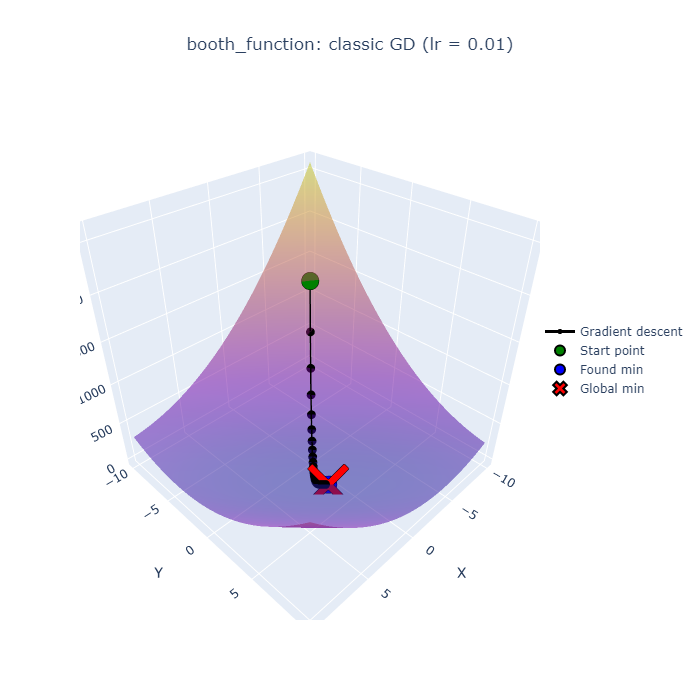

In [12]:
booth_function_path = GD(
    function=booth_function.function,
    lr=lr_1,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, booth_function_path, f'classic GD (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00247151e+00 2.99752293e+00 1.22443872e-05]
Global min:	[1 3 0]
Error: 1.2244387159651631e-05
Iterations cnt:	10001


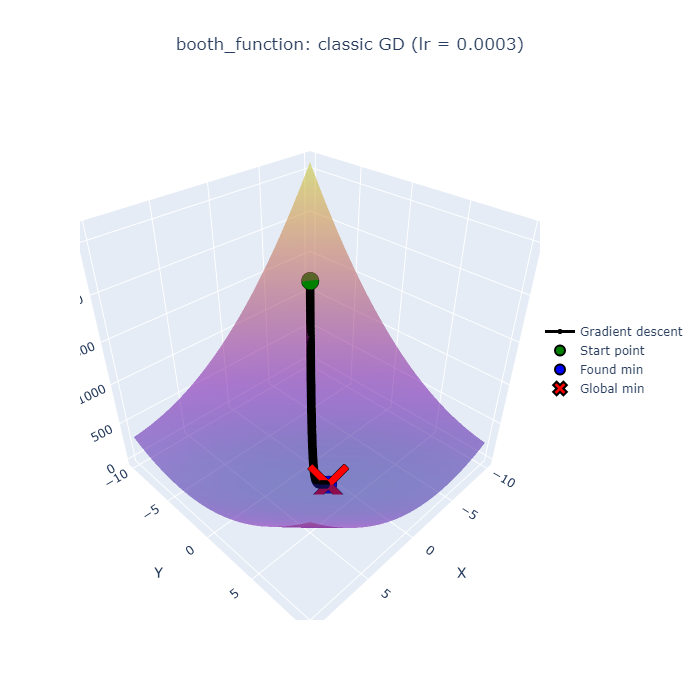

In [13]:
booth_function_path = GD(
    function=booth_function.function,
    lr=lr_2,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, booth_function_path, f'classic GD (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Классический GD с $\alpha = 1 \cdot 10^{-2}$ и $\alpha = 3 \cdot 10^{-4}$ для функции Шаффера N2

In [14]:
lr_1, lr_2 = 1e-2, 3e-4

Start point:	[10.         10.          0.15277778]
Found min:	[8.59827719 8.59827719 0.12051763]
Global min:	[0 0 0]
Error: 0.12051763444806246
Iterations cnt:	10001


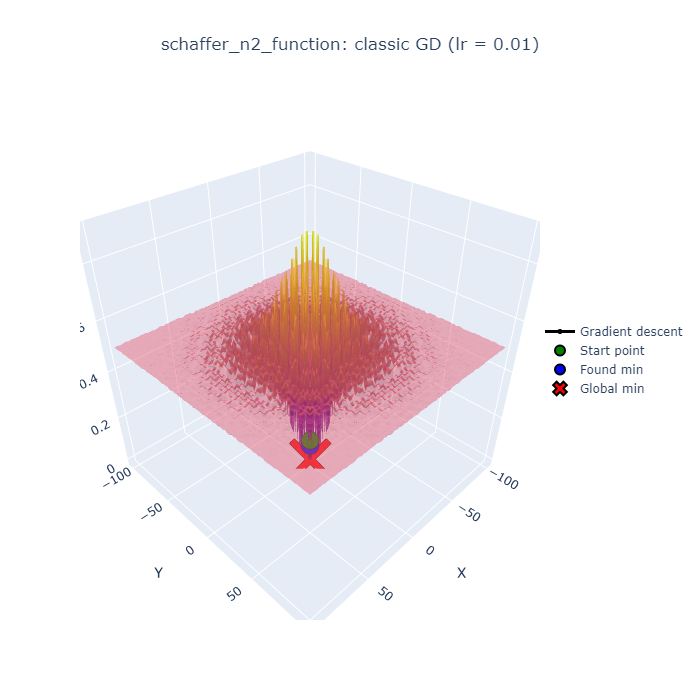

In [15]:
schaffer_n2_function_path = GD(
    function=schaffer_n2_function.function,
    lr=lr_1,
    start_point=np.array([10, 10]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, schaffer_n2_function_path, f'classic GD (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[10.         10.          0.15277778]
Found min:	[9.95696853 9.95696853 0.15178168]
Global min:	[0 0 0]
Error: 0.15178168417754273
Iterations cnt:	10001


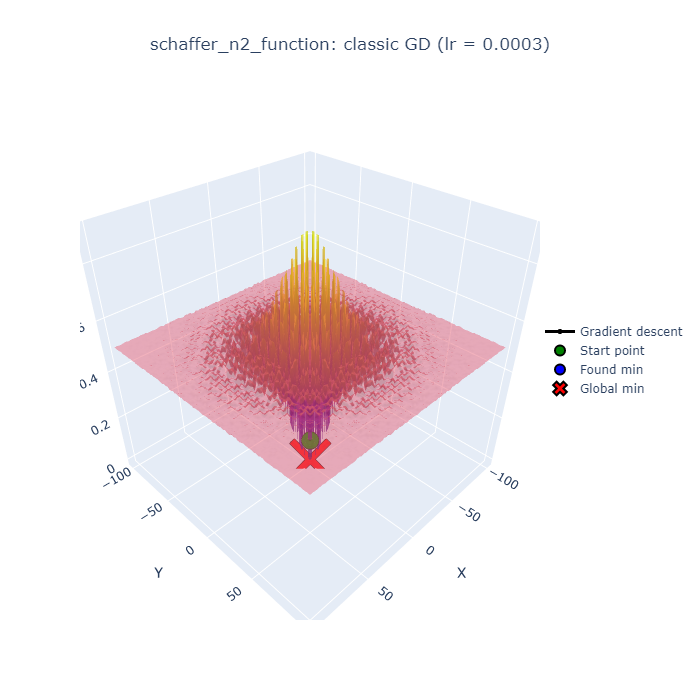

In [16]:
schaffer_n2_function_path = GD(
    function=schaffer_n2_function.function,
    lr=lr_2,
    start_point=np.array([10, 10]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, schaffer_n2_function_path, f'classic GD (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Выводы для классического GD:
- для функции Бута GD находит точку минимума при ибоих $\alpha$;
- для функции Шаффера N2 GD при обоих $\alpha$ застревает в одном из локальных минимумов и не может достичь глобального минимума.

Запрограммируем одну из моментных модификаций GD. Например, Nesterov Momentum:

\begin{equation*}
    \begin{cases}
        v_{k+1} = \beta_{k}v_{k} - \alpha_{k}\nabla f(x_{k} + \beta_{k}v_{k}), \\
        x_{k+1} = x_{k} + v_{k+1}
    \end{cases}
\end{equation*}

In [17]:
def GD_Nesterov(function, lr, start_point, real_min, conv_radius=CONV_RAD, max_steps=MAX_ITER_STEPS, beta=0.9):
    x_0, y_0 = start_point
    path = [np.array([start_point[0], start_point[1], function(x_0, y_0)])]
    point = start_point
    velocity = np.zeros_like(start_point)
    step = 0

    while np.linalg.norm(path[-1] - real_min) > conv_radius and step < max_steps:
        lookahead_point = point + beta * velocity
        gradient = grad(function, (lookahead_point[0], lookahead_point[1]))

        velocity = beta * velocity - lr * gradient
        point = point + velocity

        x, y = point
        path.append(np.array([x, y, function(x, y)]))
        step += 1

    return np.array(path)


Nesterov Momentum с $\alpha = 1 \cdot 10^{-2}$ и $\alpha = 3 \cdot 10^{-4}$ для функции Бута

In [18]:
lr_1, lr_2 = 1e-2, 3e-4

Start point:	[  -7.   -7. 1460.]
Found min:	[9.99999164e-01 2.99999528e+00 1.46314435e-10]
Global min:	[1 3 0]
Error: 1.4631443511725385e-10
Iterations cnt:	135


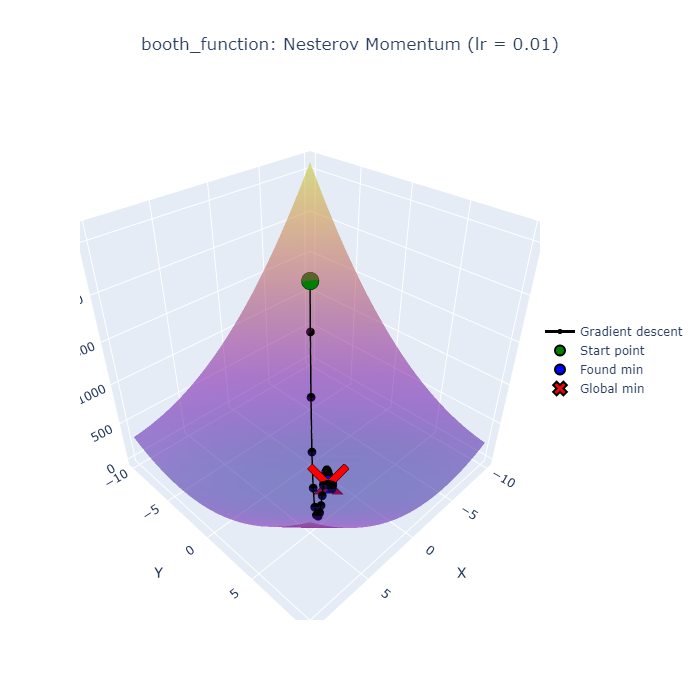

In [19]:
NM_booth_path = GD_Nesterov(
    function=booth_function.function,
    lr=lr_1,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, NM_booth_path, f'Nesterov Momentum (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00000369e+00 2.99999075e+00 2.22578572e-10]
Global min:	[1 3 0]
Error: 2.2257857187647528e-10
Iterations cnt:	1893


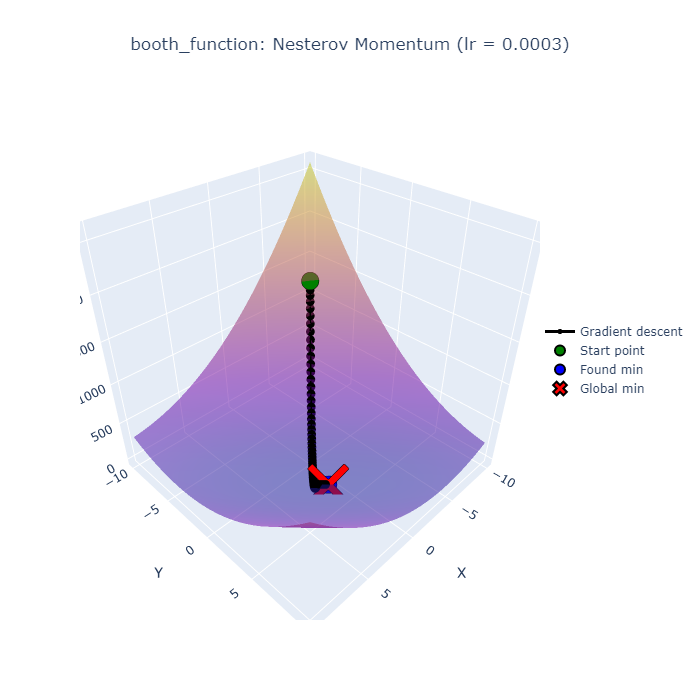

In [20]:
NM_booth_path = GD_Nesterov(
    function=booth_function.function,
    lr=lr_2,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, NM_booth_path, f'Nesterov Momentum (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Nesterov Momentum с $\alpha = 1 \cdot 10^{-2}$ и $\alpha = 3 \cdot 10^{-4}$ для функции Шаффера N2

In [21]:
lr_1, lr_2 = 1e-2, 3e-4

Start point:	[-1.5         1.3         0.28386527]
Found min:	[-1.85629827e-01  1.85624809e-01  6.89078827e-05]
Global min:	[0 0 0]
Error: 6.890788274815929e-05
Iterations cnt:	10001


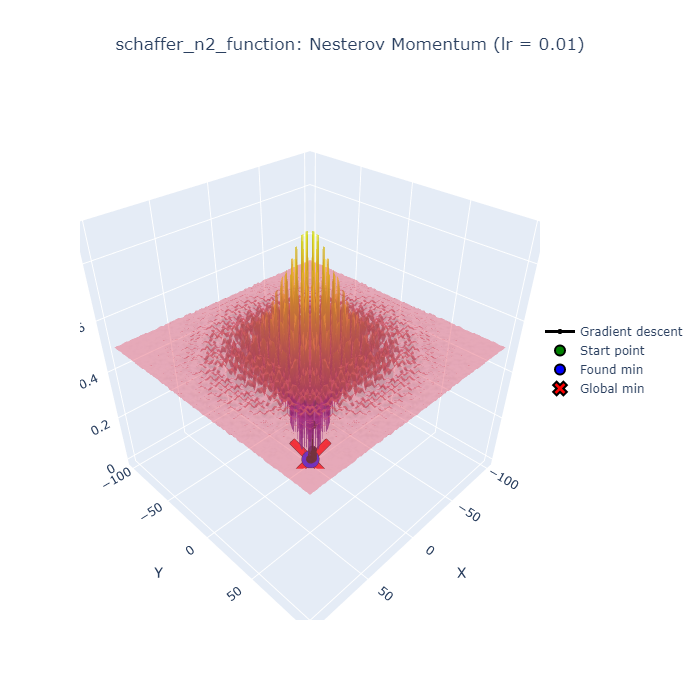

In [22]:
NM_schaffer_n2_booth_path = GD_Nesterov(
    function=schaffer_n2_function.function,
    lr=lr_1,
    start_point=np.array([-1.5, 1.3]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, NM_schaffer_n2_booth_path, f'Nesterov Momentum (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[-1.5         1.3         0.28386527]
Found min:	[-1.31379932  1.31379432  0.00343433]
Global min:	[0 0 0]
Error: 0.00343433052925185
Iterations cnt:	10001


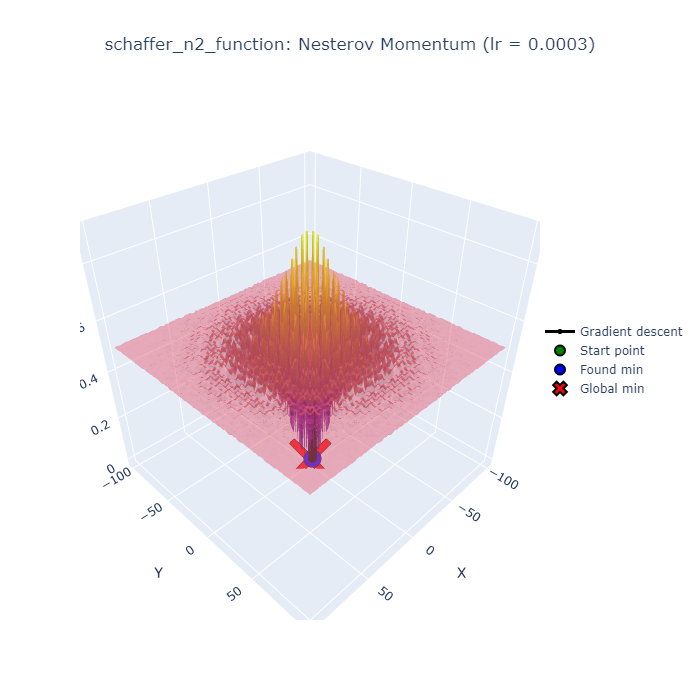

In [23]:
NM_schaffer_n2_booth_path = GD_Nesterov(
    function=schaffer_n2_function.function,
    lr=lr_2,
    start_point=np.array([-1.5, 1.3]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, NM_schaffer_n2_booth_path, f'Nesterov Momentum (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Выводы для Nesterov Momentum:
- для функции Бута GD находит точку минимума при ибоих $\alpha$, при этом для $\alpha = 3 \cdot 10^{-4}$ алгоритм совершает сильно больше итераций;
- для функции Шаффера N2 GD при обоих $\alpha$ по-прежнему застревает в одном из локальных минимумов и не может достичь глобального минимума, но значительно ближе подбирается к глобальному минимуму, чем классический GD.

Запрограммируем одну из адаптивных модификаций GD. Например, Adam:

\begin{equation*}
    \begin{cases}
        v_{k+1} = \beta_{1}v_{k} + (1 - \beta_{1}) \nabla f(x_{k}), \\
        G_{k+1} = \beta_{2}G_{k} + (1 - \beta_{2})(\nabla f(x_{k}))^{2}, \\ 
        x_{k+1} = x_{k} - \frac{\alpha}{\sqrt{G_{k+1} + \varepsilon}}v_{k+1},
    \end{cases}
\end{equation*}

где положим $\beta_{1} = 0.9$, $\beta_{2} = 0.99$ и $\varepsilon = 1 \cdot 10^{-8}$

In [24]:
def Adam(function, lr, start_point, real_min, conv_radius=CONV_RAD, max_steps=MAX_ITER_STEPS, betas=(0.9, 0.99)):
    x_0, y_0 = start_point
    path = [np.array([start_point[0], start_point[1], function(x_0, y_0)])]
    point = start_point
    step = 0
    m = np.array([0, 0])
    v = np.array([0, 0])

    while np.linalg.norm(path[-1] - real_min) > conv_radius and step < max_steps:
        m = betas[0] * m + (1 - betas[0]) * grad(function, point)
        v = betas[1] * v + (1 - betas[1]) * grad(function, point) ** 2
        point = point - lr * m / (np.sqrt(v) + 1e-8)

        x, y = point
        path.append(np.array([point[0], point[1], function(x, y)]))
        step += 1

    return np.array(path)


Adam с $\alpha = 1 \cdot 10^{-1}$ и $\alpha = 3 \cdot 10^{-3}$ для функции Бута

In [25]:
lr_1, lr_2 = 1e-1, 3e-3

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00000047e+00 2.99999395e+00 1.61000361e-10]
Global min:	[1 3 0]
Error: 1.6100036145704777e-10
Iterations cnt:	528


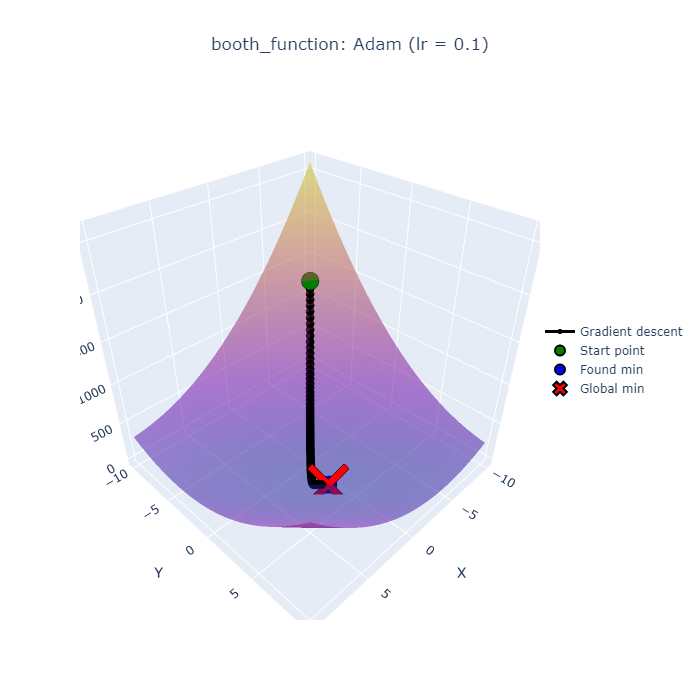

In [26]:
Adam_booth_path = Adam(
    function=booth_function.function,
    lr=lr_1,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, Adam_booth_path, f'Adam (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00000320e+00 2.99999068e+00 2.46820640e-10]
Global min:	[1 3 0]
Error: 2.468206399730537e-10
Iterations cnt:	4085


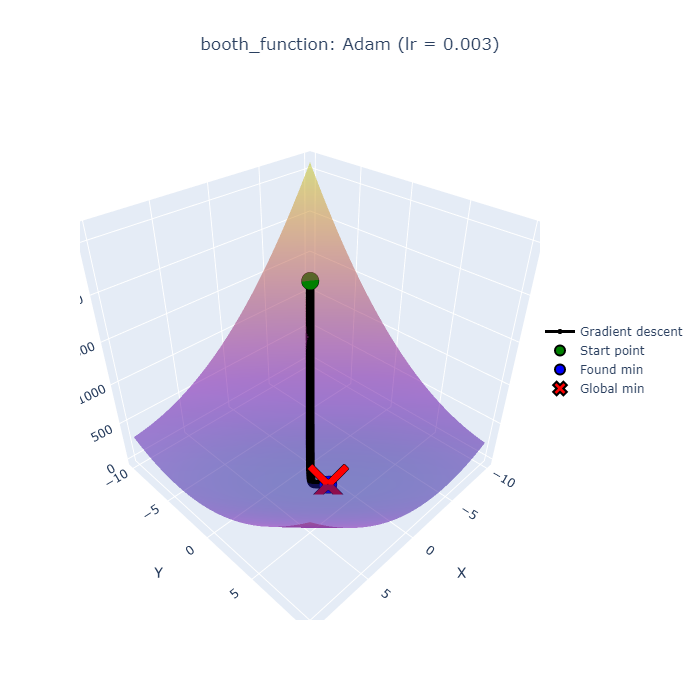

In [27]:
Adam_booth_path = Adam(
    function=booth_function.function,
    lr=lr_2,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, Adam_booth_path, f'Adam (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Adam с $\alpha = 1 \cdot 10^{-1}$ и $\alpha = 3 \cdot 10^{-4}$ для функции Шаффера N2

In [28]:
lr_1, lr_2 = 1e-1, 3e-4

Start point:	[-3.          3.          0.01752541]
Found min:	[-6.69598588e-06 -2.13520533e-06  4.92939023e-14]
Global min:	[0 0 0]
Error: 4.929390229335695e-14
Iterations cnt:	1300


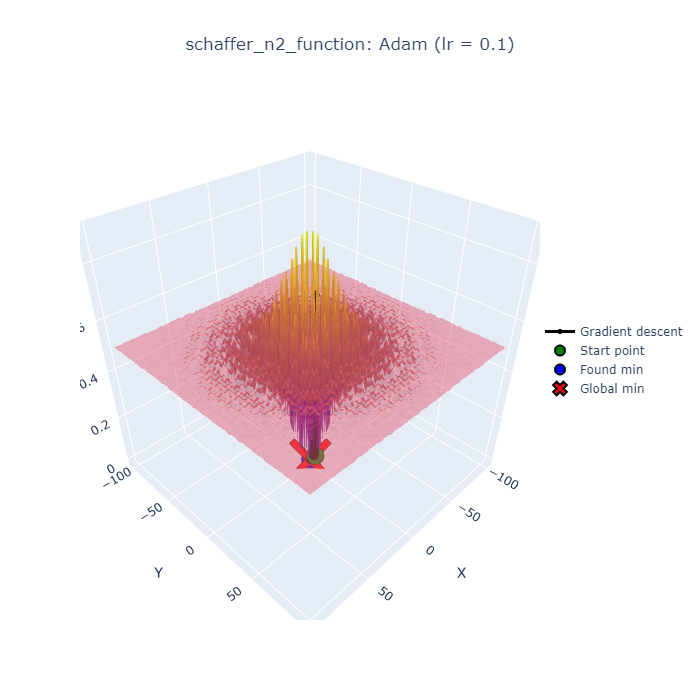

In [29]:
Adam_shuffer_n2_path = Adam(
    function=schaffer_n2_function.function,
    lr=lr_1,
    start_point=np.array([-3, 3]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, Adam_shuffer_n2_path, f'Adam (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[-3.          3.          0.01752541]
Found min:	[-7.04376663e-02  7.06287237e-02  9.95045934e-06]
Global min:	[0 0 0]
Error: 9.95045933949168e-06
Iterations cnt:	10001


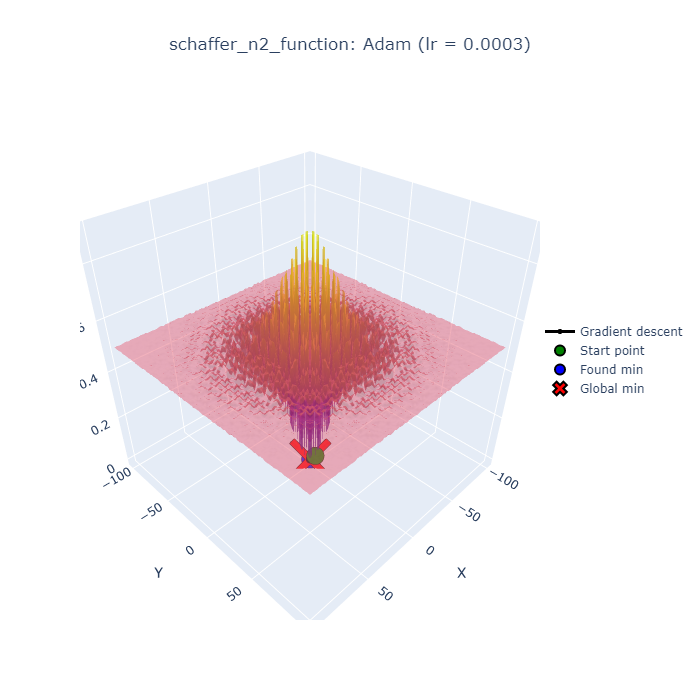

In [30]:
Adam_shuffer_n2_path = Adam(
    function=schaffer_n2_function.function,
    lr=lr_2,
    start_point=np.array([-3, 3]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, Adam_shuffer_n2_path, f'Adam (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Выводы для Adam:
- для функции Бута Adam находит точку минимума при ибоих $\alpha$;
- для функции Шаффера N2 Adam находит точку минимума при ибоих $\alpha$;.

Запрограммируем метод эволюции темпа обучения. Например, экспоненциальный (Exponential Learning Rate Decay):

\begin{equation*}
    x_{k+1} = x_{k} - \alpha_{k} \nabla f(x_{k}),
\end{equation*}

где $\alpha_{k} = \alpha_{0} \cdot e^{-\lambda k}$

In [31]:
def GD_with_exponential_lr(function, lr, start_point, real_min, conv_radius=CONV_RAD, max_steps=MAX_ITER_STEPS, l=0.01):

    def learning_rate_schedule(step):
        return lr * np.exp(-l * step)

    x_0, y_0 = start_point
    path = [np.array([x_0, y_0, function(x_0, y_0)])]
    point = start_point
    step = 0

    while np.linalg.norm(path[-1] - real_min) > conv_radius and step < max_steps:
        gradient = grad(function, point)
        current_lr = learning_rate_schedule(step)
        point = point - current_lr * gradient
        x, y = point
        path.append(np.array([x, y, function(x, y)]))

        step += 1

    return np.array(path)

ELRD с $\alpha = 1 \cdot 10^{-3}$ и $\alpha = 3 \cdot 10^{-2}$ для функции Бута

In [32]:
lr_1, lr_2 = 1e-3, 1e-2

Start point:	[  -7.   -7. 1460.]
Found min:	[1.30734528 2.63161685 0.24506975]
Global min:	[1 3 0]
Error: 0.2450697500459386
Iterations cnt:	10001


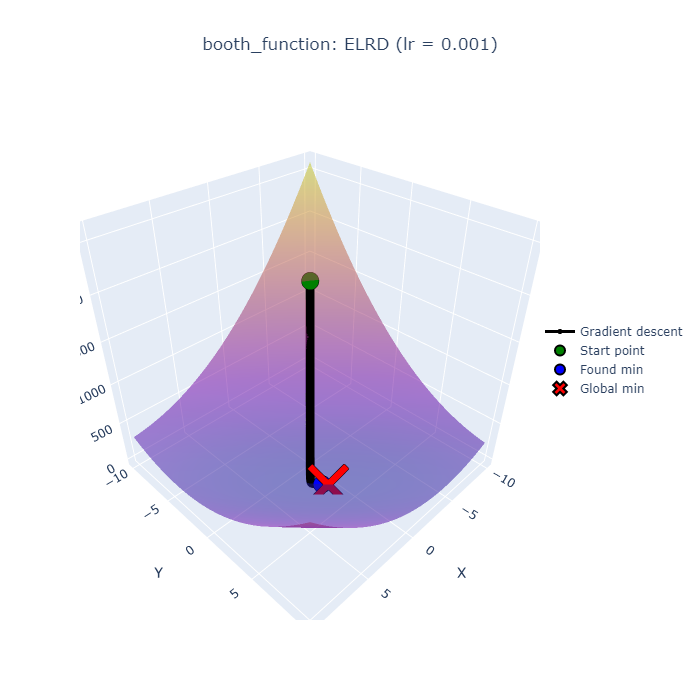

In [33]:
Exp_booth_path = Adam(
    function=booth_function.function,
    lr=lr_1,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, Exp_booth_path, f'ELRD (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[  -7.   -7. 1460.]
Found min:	[1.00000358e+00 2.99999069e+00 2.31064977e-10]
Global min:	[1 3 0]
Error: 2.3106497657762452e-10
Iterations cnt:	1744


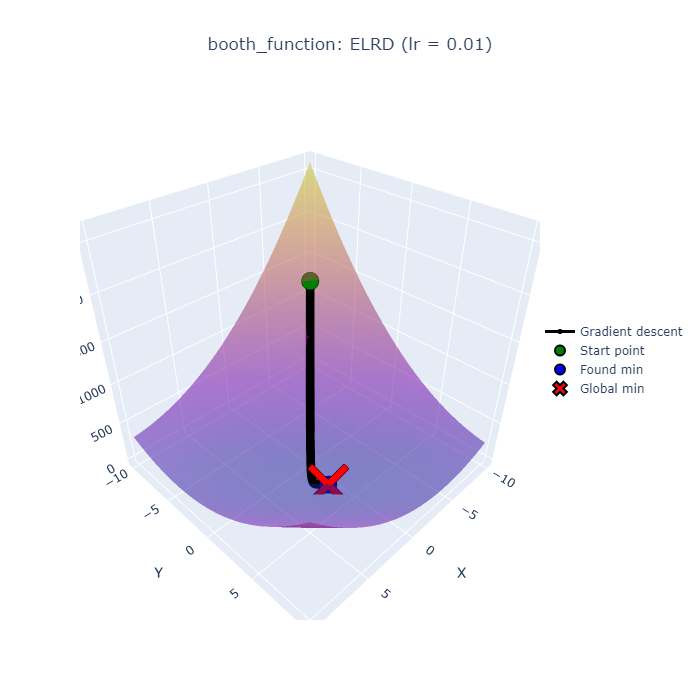

In [34]:
Exp_booth_path = Adam(
    function=booth_function.function,
    lr=lr_2,
    start_point=np.array([-7, -7]),
    real_min=booth_function.real_min,
)

fig = visualize_GD_static(booth_function, Exp_booth_path, f'ELRD (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

ELRD с $\alpha = 1 \cdot 10^{-2}$ и $\alpha = 3 \cdot 10^{-1}$ для функции Шаффера N2

In [35]:
lr_1, lr_2 = 1e-2, 3e-1

Start point:	[-20.          30.           0.44684508]
Found min:	[-20.14438686  29.77347224   0.40484236]
Global min:	[0 0 0]
Error: 0.4048423576470135
Iterations cnt:	10001


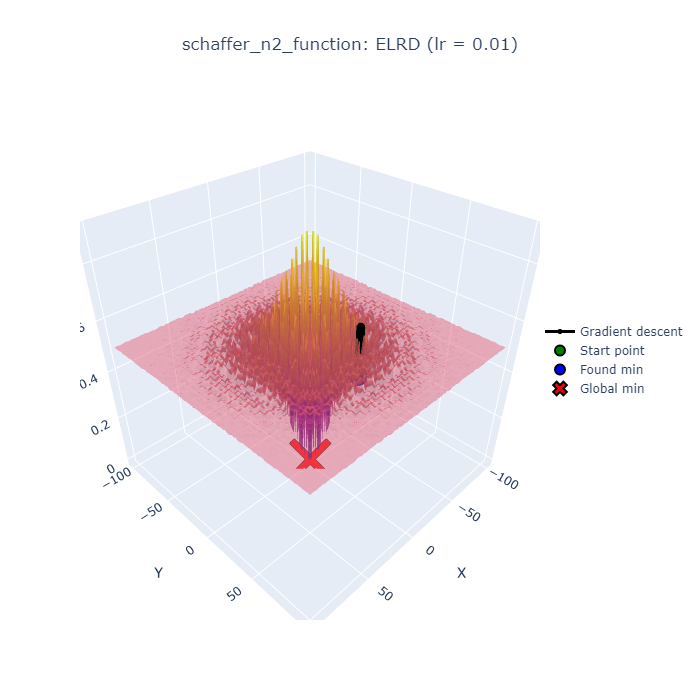

In [36]:
Exp_shuffer_n2_path = GD_with_exponential_lr(
    function=schaffer_n2_function.function,
    lr=lr_1,
    start_point=np.array([-20, 30]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, Exp_shuffer_n2_path, f'ELRD (lr = {lr_1})')

fig.write_image("fig.png")
Image("fig.png")

Start point:	[-20.          30.           0.44684508]
Found min:	[-21.57080093  19.09890877   0.35070831]
Global min:	[0 0 0]
Error: 0.35070831008437453
Iterations cnt:	10001


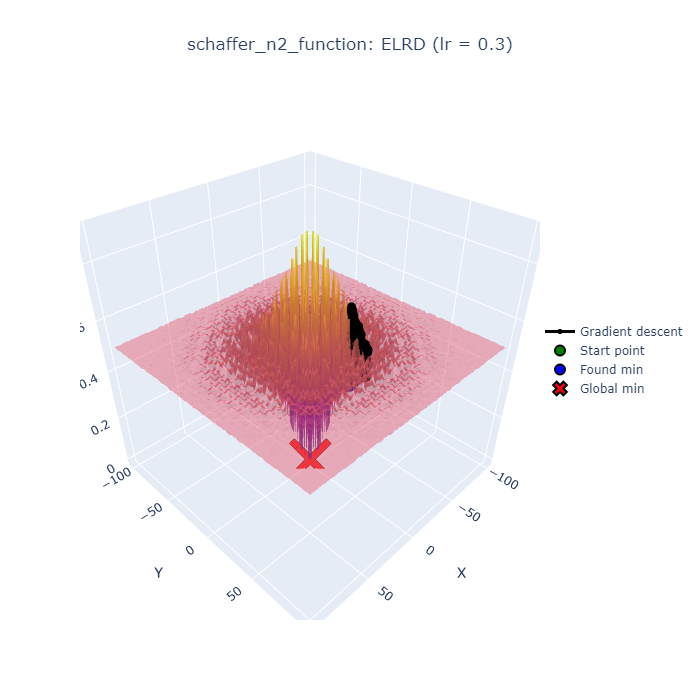

In [37]:
Exp_shuffer_n2_path = GD_with_exponential_lr(
    function=schaffer_n2_function.function,
    lr=lr_2,
    start_point=np.array([-20, 30]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, Exp_shuffer_n2_path, f'ELRD (lr = {lr_2})')

fig.write_image("fig.png")
Image("fig.png")

Выводы для Exponential Learning Rate Decay:
- для функции Бута GD находит точку минимума при ибоих $\alpha$;
- для функции Шаффера N2 GD при обоих $\alpha$ по-прежнему застревает в одном из локальных минимумов и не может достичь глобального минимума.

Попробем воспользоваться воспользоваться [методом оптимизации роя частиц (PSO)](https://habr.com/ru/companies/bothub/articles/842006/). Здесь, в отличие от методов выше, начальное положение (srart_point) задаётся случайным образом.


\begin{equation*}
    \begin{cases}
        \mathbf{v}_i^{t+1} = w \mathbf{v}_i^t + c_1 r_1 (\mathbf{p}_i - \mathbf{x}_i^t) + c_2 r_2 (\mathbf{g} - \mathbf{x}_i^t), \\
        \mathbf{x}_i^{t+1} = \mathbf{x}_i^t + \mathbf{v}_i^{t+1}
    \end{cases}
\end{equation*}

Условие обновления личного лучшего решения
\begin{equation*}
\mathbf{p}_i = 
    \begin{cases} 
        \mathbf{x}_i^t & \text{если } f(\mathbf{x}_i^t) < f(\mathbf{p}_i) \\
        \mathbf{p}_i & \text{иначе}.
    \end{cases}
\end{equation*}

Условие обновления глобального лучшего решения
\begin{equation*}
\mathbf{g} = 
    \begin{cases} 
        \mathbf{x}_i^t & \text{если } f(\mathbf{x}_i^t) < f(\mathbf{g}) \\
        \mathbf{g} & \text{иначе}.
    \end{cases}
\end{equation*}

In [38]:
def particle_swarm_optimization(function, start_point, real_min, bounds=None, num_particles=30, max_iterations=1000, inertia=0.7, cognitive=1.5, social=1.5):
    dim = len(bounds)
    lower_bounds, upper_bounds = np.array(bounds).T

    positions = np.random.uniform(lower_bounds, upper_bounds, (num_particles, dim))
    positions[0] = start_point
    velocities = np.random.uniform(-1, 1, (num_particles, dim))
    personal_best_positions = positions.copy()
    personal_best_values = np.array([function(*p) for p in positions])

    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index].copy()
    global_best_value = personal_best_values[global_best_index]

    path = [np.array([global_best_position[0], global_best_position[1], global_best_value])]

    for _ in range(max_iterations):
        for i in range(num_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            velocities[i] = (inertia * velocities[i] +
                             cognitive * r1 * (personal_best_positions[i] - positions[i]) +
                             social * r2 * (global_best_position - positions[i]))

            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], lower_bounds, upper_bounds)

            value = function(*positions[i])

            if value < personal_best_values[i]:
                personal_best_positions[i] = positions[i].copy()
                personal_best_values[i] = value

                if value < global_best_value:
                    global_best_position = positions[i].copy()
                    global_best_value = value

        path.append(np.array([global_best_position[0], global_best_position[1], global_best_value]))

        if global_best_value < 1e-8:
            break

    return np.array(path)

Start point:	[-25.62262422 -77.27798178   0.49213491]
Found min:	[-2.08258546e-03  2.89679232e-04  4.43916626e-09]
Global min:	[0 0 0]
Error: 4.439166256808846e-09
Iterations cnt:	58


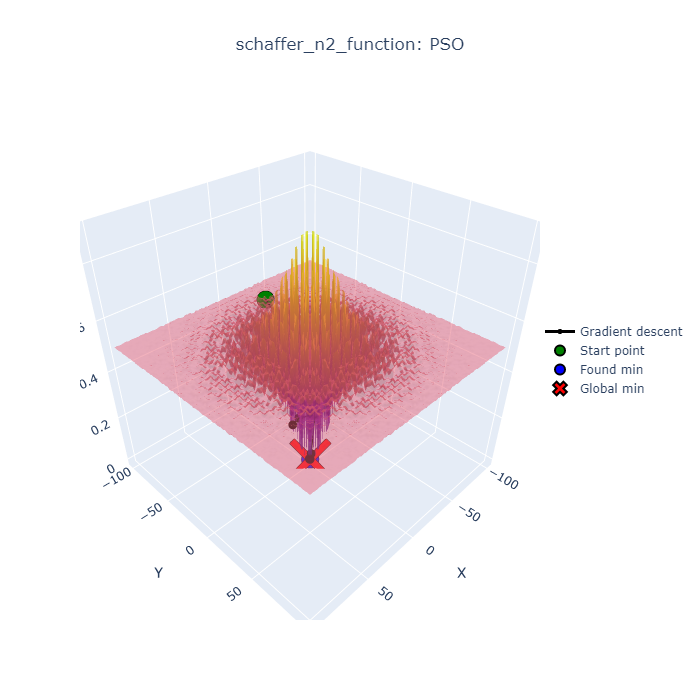

In [39]:
PSO_shuffer_n2_path = particle_swarm_optimization(
    function=schaffer_n2_function.function,
    start_point=np.array([-100, -100]),
    bounds=np.array([(-200, 200), (-200, 200)]),
    real_min=schaffer_n2_function.real_min,
)

fig = visualize_GD_static(schaffer_n2_function, PSO_shuffer_n2_path, 'PSO')

fig.write_image("fig.png")
Image("fig.png")

Как видим, PSO справился с поиском глобально минимума для функции Шаффера N2.